# TASK C.3 

## Importing Libraries

In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import json
from pprint import pprint
import matplotlib.pyplot as plt

In [2]:
import gmaps

In [3]:
import gmplot
# gmplot contains a simple wrapper around 
# Google’s geocoding service enabling map initilization to the location of your choice.
gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city



## Task C.3.a.i.

For the incoming climate data a line graph of air temperature against arrival time. Labeled some interesting points such as maximum and minimum values.

<IPython.core.display.Javascript object>


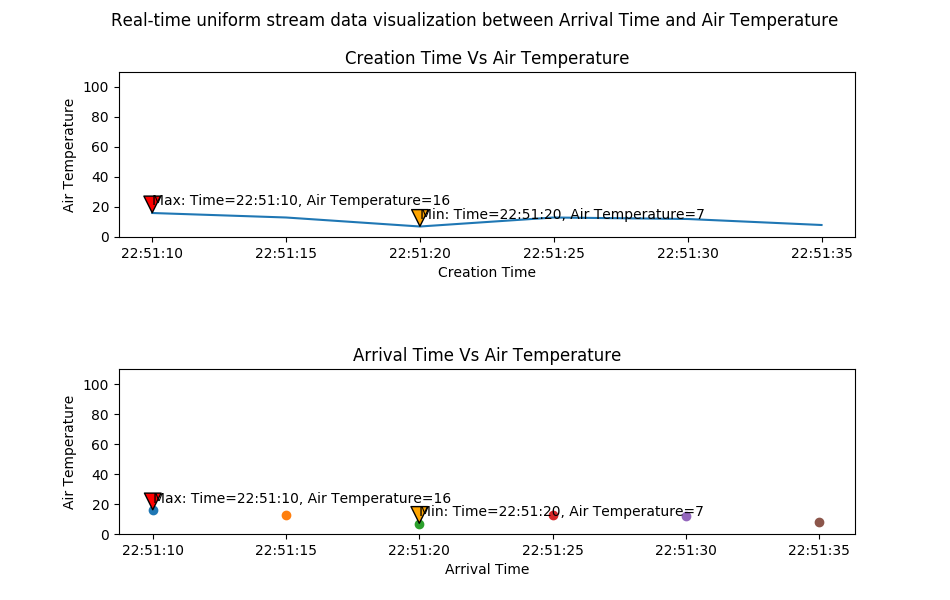

KeyboardInterrupt: 

In [4]:
#Consumer 
from time import sleep
from kafka import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook

#Connection topic
topic = 'climateHotspotData'
#To find the max values
def annotate_max(x, y, ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Air Temperature={}'.format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax, ymax+5), arrowprops=dict(facecolor='red', shrink=0.05),)
    
def annotate_min(x, y, ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Air Temperature={}'.format(xmin, ymin)
    if not ax:
        ax=plt.gca()
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin, ymin+5), arrowprops=dict(facecolor='orange', shrink=0.05),)

def connect_kafka_consumer():
    _consumer = None
    try:
         _consumer = KafkaConsumer(topic,
                                   consumer_timeout_ms=10000, # stop iteration if no message after 10 sec
                                   auto_offset_reset='earliest', # comment this if you don't want to consume earliest available message
                                   bootstrap_servers=['127.0.0.1:9092'],
                                   api_version=(0, 10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return _consumer



#Plot function
def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width,height)) # create new figure
        fig.subplots_adjust(hspace=0.8)

        ax1 = fig.add_subplot(211)
        ax2 = fig.add_subplot(212)
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Air Temperature')
        ax1.title.set_text('Creation Time Vs Air Temperature')
        ax2.set_xlabel('Time')
        ax2.set_ylabel('Air Temperature')
        ax2.title.set_text('Arrival Time Vs Air Temperature')
        fig.suptitle('Real-time uniform stream data visualization between Arrival Time and Air Temperature') # giving figure a title
        fig.show() # displaying the figure
        fig.canvas.draw() # drawing on the canvas
        return fig, ax1, ax2
    except Exception as ex:
        print(str(ex))
    
#The data from the producer is read and split
#The arrival time is splitted from created time
#Air temperature celsius is also splitted from the producer data
def consume_messages(consumer,fig,ax1,ax2):
    try:
        x1, y1 = [], []
        x2, y2 = [], []
        for message in consumer:
            data = str(message.value.decode('utf-8'))
            if "climate" in data: #Only for climate data
                peek=data.split(',')
                air_temp=peek[2]
                split_air=air_temp.split(":")
                air_temperature=split_air[1] #considering only air temperature in celcius value
                time_var=peek[7]
                split_time=time_var.split(" ")
                arrival_time=split_time[1].strip('\"')
                x1.append(arrival_time) 
                y1.append(int(air_temperature))
                x2.append(arrival_time)
                y2.append(int(air_temperature))
                # print(y)
                # we start plotting only when we have 10 data points
                if len(y1) > 5:
                    ax1.clear()
                    ax1.plot(x1, y1)
                    ax1.set_xlabel('Creation Time')
                    ax1.set_ylabel('Air Temperature')
                    ax1.set_title('Creation Time Vs Air Temperature')
                    ax1.set_ylim(0,110) 
                    ax1.set_yticks([0,20,40,60,80,100])
                    annotate_max(x1, y1, ax1)
                    annotate_min(x1, y1, ax1)

            if len(y2) > 5: 
                    ax2.clear()
                    for xe, ye in zip(x2, y2): # we can have more than one data in one arrival time
                        ax2.scatter(xe, ye)
                    # ax2.plot(x2, y2)
                    ax2.set_xlabel('Arrival Time')
                    ax2.set_ylabel('Air Temperature')
                    ax2.set_title('Arrival Time Vs Air Temperature')
                    ax2.set_ylim(0,110) 
                    ax2.set_yticks([0,20,40,60,80,100])
                    annotate_max(x2, y2, ax2)
                    annotate_min(x2, y2, ax2)

                    fig.canvas.draw()
                    x1.pop(0) # removing the item in the first position
                    y1.pop(0)
                    x2.pop(0) # removing the item in the first position
                    y2.pop(0)
        plt.close('all')
            
    except Exception as ex:
        print(str(ex))
    
if __name__ == '__main__':
    
    consumer = connect_kafka_consumer()
    fig, ax1, ax2 = init_plots()
    consume_messages(consumer, fig, ax1,ax2)
    
    

In [5]:
plt.close('all')

In [6]:
client = MongoClient ()

### Accessing of database

In [7]:
db=client.fit5148_assignment_db

### Accessing the collection 

In [8]:
hotspot=db.hotspot

### Taskc.3.b.i--Static visualisation

Records with the top 10 number of fires. A bar chart with time as the x-axis and number of fires as the y-axis.

In [9]:
### Records with top 10 number of fires

<IPython.core.display.Javascript object>


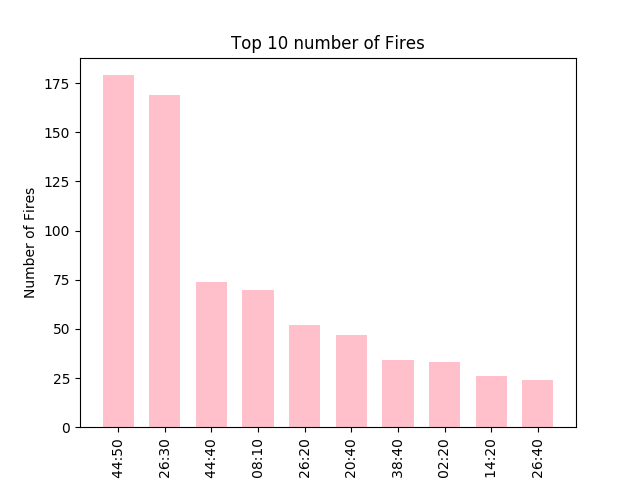

Text(0, 0.5, 'Number of Fires')

In [9]:
#Records with top 10 number of fires
aa=hotspot.aggregate( [
   { "$group": 
    { "_id": "$datetime", 'total number of fire': { "$sum": 1 }} 
   },
{ "$sort" : { 'total number of fire' : -1} },
       { "$limit": 10 }
] )

#creation of bar chart
x_ax=[]
y_ax=[]
for a in aa:
    x_ax.append(a['_id']) 
    y_ax.append(a['total number of fire']) # y axis list
x_axes=[]
for each in x_ax:
    temp=each.split('T') #x axis list considering only the time
    x_axes.append(temp[1])   
width = 1/1.5
plt.bar(x_axes, y_ax, width, color="pink") #Bar chart   
plt.xticks(rotation='vertical')
plt.title('Top 10 number of Fires')
plt.xlabel('Time')
plt.ylabel('Number of Fires')
     

## Taskc.3.b.ii

Fire locations in the map with air temperature, surface temperature, relative humidity and confidence

In [63]:
# From the hotspot data only surface temperature in celcius, confidence is taken with respect to date in climate date and air temperature and relative humidity is taken from climate data
date_match_hotspot = hotspot.aggregate([
    {
"$lookup":
    {
        "from": "climate",
        "localField": "hotspot_id",
        "foreignField" : "climate_id",
        "as": "fire"
    }
    },
    {
        "$unwind":"$fire"
    },
    {
    "$project": {
        "latitude": 1,
        "longitude": 1, 
        "surface_temperature_celcius": 1, 
        "confidence": 1,
        "fire.relative_humidity":1,
        "fire.air_temperature_celcius":1
            }
}
])

        



In [64]:
mongo_result = []
for row in date_match_hotspot:
    mongo_result.append(row)

In [65]:
len(mongo_result)

2668

In [66]:
unoccupiedList = []
for row in mongo_result:
    unoccupiedList.append((float(row['latitude']), float(row['longitude']), float(row['surface_temperature_celcius']), float(row['confidence']), float(row['fire']['relative_humidity']), float(row['fire']['air_temperature_celcius'])))

In [70]:
for tup in unoccupiedList:
    if len(tup) < 6:
        print(tup)

In [73]:
# for row in date_match1:
#     unoccupiedList.append((float(row['latitude']), float(row['longitude']), float(row['surface_temperature_celcius']), float(row['confidence']), float(row['fire']['relative_humidity']), float(row['fire']['air_temperature_celcius'])))



print(len(unoccupiedList))
# The step below is required by the gmap scatter function to prepare data in correct format
unoccupied_lats, unoccupied_lons,hstc,conf,relative_humidity,airtemp = zip(*unoccupiedList) 

gmap = gmplot.GoogleMapPlotter(-37.812015244225677, 144.951471202974, 15) # latitude and longitude of melbourne city
for i in range(0,len(unoccupiedList)):
    gmap.marker(unoccupied_lats[i], unoccupied_lons[i],title="surface temp:"+str(hstc[i])+
                " confidence:"+str(conf[i])+" air temp:"+str(airtemp[i])+" relative humidity:"+str(relative_humidity[i]))

# print(len(unoccupied_lats),len(unoccupied_lons),len(airtemp),len(relative_humidity,hstc)

# Plotting the points on the map
# gmap.scatter(unoccupied_lats, unoccupied_lons, '#FF4500', size=2, marker=False)


# Drawing the map
gmap.draw("availableParkings.html")
webbrowser.open_new("availableParkings.html")

2668


True